In [ ]:
# 코엔엘파이 설치
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 3.8MB 57.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import konlpy
import konlpy.tag
import re

from konlpy.tag import Okt
from datetime import datetime
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import RobustScaler

%matplotlib inline

# 한글 폰트
plt.rc('font', family='Malgun Gothic')

# 도화지 크기
plt.rcParams['figure.figsize'] = (10, 7)

# 숫자 표기법 변환
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 셋 만들기

In [ ]:
train = pd.read_csv("/content/drive/Shared drives/빅콘테스트2020/data/data/01_제공데이터/train.csv")
test = pd.read_csv("/content/drive/Shared drives/빅콘테스트2020/data/data/02_평가데이터/test.csv")

In [ ]:
# column name 변경
train.columns = train.iloc[0]
test.columns = test.iloc[0]

# 첫번쨰 행 삭제
train.drop([0], axis=0, inplace=True)
test.drop([0], axis=0, inplace=True)

In [ ]:
train

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2019-01-01 6:00,20,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","2,099,000"
2,2019-01-01 6:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","4,371,000"
3,2019-01-01 6:20,20,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","3,262,000"
4,2019-01-01 6:20,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","6,955,000"
5,2019-01-01 6:40,20,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","6,672,000"
...,...,...,...,...,...,...,...,...
38305,2020-01-01 0:20,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,-,NaN
38306,2020-01-01 0:40,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,-,NaN
38307,2020-01-01 1:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,-,NaN
38308,2020-01-01 1:20,20,100490,201478,더케이 예다함 상조서비스(티포트),무형,-,NaN


In [ ]:
test

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2020-06-01 6:20,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 6:40,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
4,2020-06-01 7:20,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
5,2020-06-01 7:40,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
...,...,...,...,...,...,...,...,...
2887,2020-07-01 0:20,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2888,2020-07-01 0:40,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2889,2020-07-01 1:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2890,2020-07-01 1:20,20,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",NaN


In [ ]:
# 무형 판매단가 0으로 대입
test['판매단가'] = ['0' if x == ' - ' else x for x in test['판매단가']]

In [ ]:
test

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2020-06-01 6:20,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 6:40,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
4,2020-06-01 7:20,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
5,2020-06-01 7:40,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
...,...,...,...,...,...,...,...,...
2887,2020-07-01 0:20,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2888,2020-07-01 0:40,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2889,2020-07-01 1:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2890,2020-07-01 1:20,20,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",NaN


In [ ]:
# test 원본 데이터 복제
real_test = test

# 2. 데이터 전처리

## train, test

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38309 entries, 1 to 38309
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   방송일시    38309 non-null  object
 1   노출(분)   21525 non-null  object
 2   마더코드    38309 non-null  object
 3   상품코드    38309 non-null  object
 4   상품명     38309 non-null  object
 5   상품군     38309 non-null  object
 6   판매단가    38309 non-null  object
 7    취급액    35379 non-null  object
dtypes: object(8)
memory usage: 2.6+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2891 entries, 1 to 2891
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   방송일시    2891 non-null   object
 1   노출(분)   1780 non-null   object
 2   마더코드    2891 non-null   object
 3   상품코드    2891 non-null   object
 4   상품명     2891 non-null   object
 5   상품군     2891 non-null   object
 6   판매단가    2891 non-null   object
 7   취급액     0 non-null      object
dtypes: object(8)
memory usage: 203.3+ KB


In [ ]:
train.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2019-01-01 6:00,20,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","2,099,000"
2,2019-01-01 6:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","4,371,000"
3,2019-01-01 6:20,20,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","3,262,000"
4,2019-01-01 6:20,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","6,955,000"
5,2019-01-01 6:40,20,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","6,672,000"


In [ ]:
test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2020-06-01 6:20,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 6:40,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
4,2020-06-01 7:20,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
5,2020-06-01 7:40,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN


### column name 변경

In [ ]:
train.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', ' 취급액 '], dtype='object', name=0)

In [ ]:
test.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object', name=0)

In [ ]:
train.rename({' 취급액 ':'취급액'}, axis=1, inplace=True)

### 판매단가, 취급액 타입 변경

In [ ]:
# 쉼표 제거
train['취급액'] = [x.replace(',','').strip() if str(type(x)) != "<class 'float'>" else x for x in train['취급액']]
train['판매단가'] = [x.replace(',','').strip() for x in train['판매단가']]

test['판매단가'] = [x.replace(',','').strip() for x in test['판매단가']]

In [ ]:
# 취급액 NaN 제거
train = train[~train['취급액'].isna()]
train = train.reset_index().drop(['index'], axis=1)

In [ ]:
#------------- 임시
# test_temp = test[test['판매단가'] == '-']
# embedding 차원 미리 추가
# temp = pd.DataFrame(svd_model.components_.T)
# train = pd.concat([train, temp.iloc[:35379]], axis=1)
# test = pd.concat([test.reset_index().drop(['index'], axis=1), 
#                   temp.iloc[35379:].reset_index().drop(['index'], axis=1)], axis=1)

# test = test[test['판매단가'] != '-']

In [ ]:
# 판매단가, 취급액 int로 변환 
train['판매단가'] = [int(x) for x in train['판매단가']]
train['취급액'] = [int(x) for x in train['취급액']]

test['판매단가'] = [int(x) for x in test['판매단가']]

### 방송일시 column을 바탕으로 날짜, 시, 분 column 만들기

In [ ]:
# 날짜 column 생성
train['날짜'] = [x[:10] for x in train['방송일시']]
train['날짜'] = [datetime.strptime(x, '%Y-%m-%d') for x in train['날짜']]

test['날짜'] = [x[:10] for x in test['방송일시']]
test['날짜'] = [datetime.strptime(x, '%Y-%m-%d') for x in test['날짜']]

In [ ]:
# 방송일시 date type변경
train['방송일시'] = [datetime.strptime(x, '%Y-%m-%d %H:%M') for x in train['방송일시']]

test['방송일시'] = [datetime.strptime(x, '%Y-%m-%d %H:%M') for x in test['방송일시']]

In [ ]:
train['시'] = [x.hour for x in train['방송일시']]
test['시'] = [x.hour for x in test['방송일시']]

In [ ]:
train['분'] = [x.minute for x in train['방송일시']]
test['분'] = [x.minute for x in test['방송일시']]

In [ ]:
final = train.set_index('날짜')
temp = final.pivot_table(index='시', columns='상품군', aggfunc='mean', values='취급액')

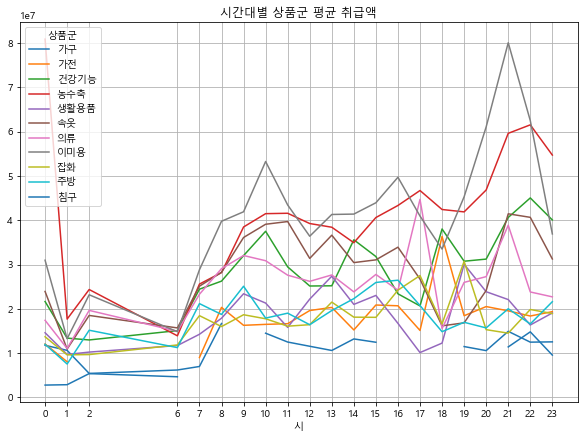

In [ ]:
temp.plot()
plt.title('시간대별 상품군 평균 취급액')
plt.xticks(temp.index)
plt.grid(True)

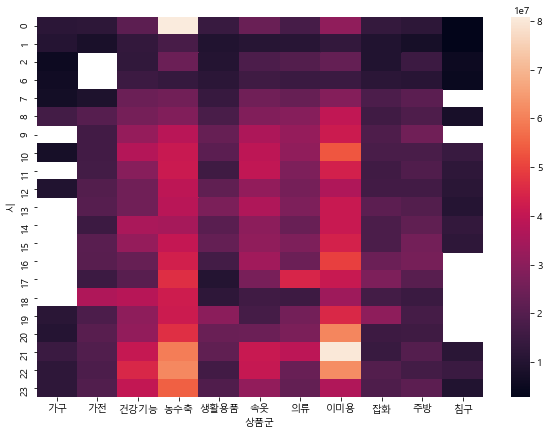

In [ ]:
sns.heatmap(temp)

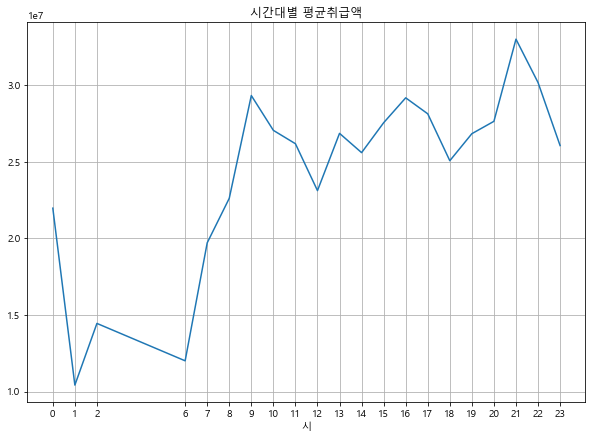

In [ ]:
temp.mean(axis=1).plot()
plt.title('시간대별 평균취급액')
plt.xticks(temp.index)
plt.grid(True)

### 요일 column 만들기

In [ ]:
mon = pd.date_range(start='20190101', end='20200701', freq='W-MON')
tue = pd.date_range(start='20190101', end='20200701', freq='W-TUE')
wed = pd.date_range(start='20190101', end='20200701', freq='W-WED')
thu = pd.date_range(start='20190101', end='20200701', freq='W-THU')
fri = pd.date_range(start='20190101', end='20200701', freq='W-FRI')
sat = pd.date_range(start='20190101', end='20200701', freq='W-SAT')
sun = pd.date_range(start='20190101', end='20200701', freq='W-SUN')

In [ ]:
lst = []

for i in tqdm(range(train.shape[0])):
    temp = str(train.iloc[i]['날짜'])[:10]
    if temp in mon:
        lst.append('월')
    elif temp in tue:
        lst.append('화')
    elif temp in wed:
        lst.append('수')
    elif temp in thu:
        lst.append('목')
    elif temp in fri:
        lst.append('금')
    elif temp in sat:
        lst.append('토')
    else:
        lst.append('일')
        
train['요일'] = lst


lst2 = []

for i in tqdm(range(test.shape[0])):
    temp = str(test.iloc[i]['날짜'])[:10]
    if temp in mon:
        lst2.append('월')
    elif temp in tue:
        lst2.append('화')
    elif temp in wed:
        lst2.append('수')
    elif temp in thu:
        lst2.append('목')
    elif temp in fri:
        lst2.append('금')
    elif temp in sat:
        lst2.append('토')
    else:
        lst2.append('일')
        
test['요일'] = lst2

100%|██████████| 2891/2891 [00:02<00:00, 1172.77it/s]


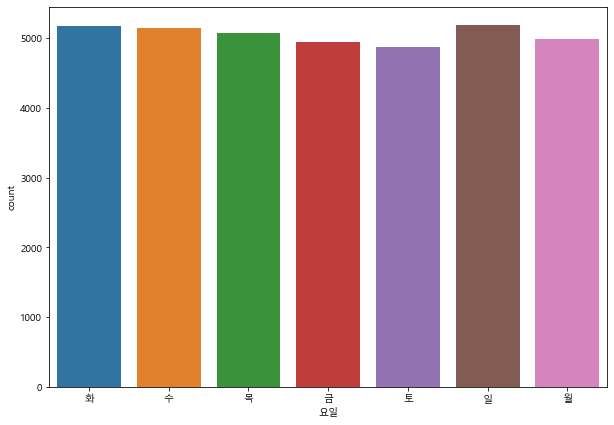

In [ ]:
sns.countplot(train['요일'])

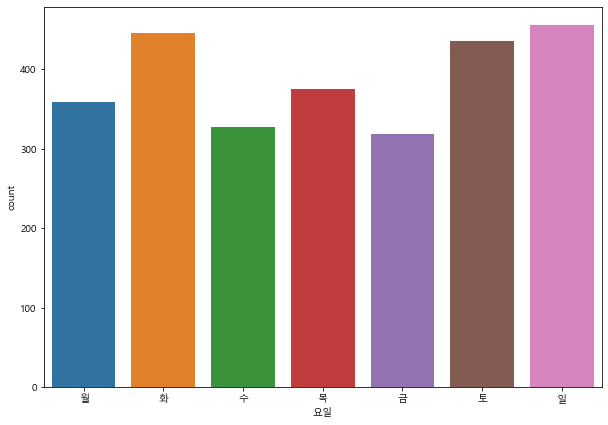

In [ ]:
sns.countplot(test['요일'])

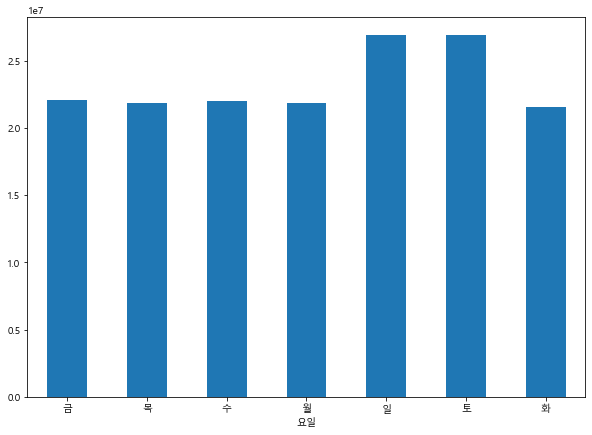

In [ ]:
final = train.set_index('날짜')
temp = final.pivot_table(index='요일', columns='상품군', aggfunc='mean', values='취급액')
temp.mean(axis=1).plot(kind='bar', rot=0)

### 휴일변수 생성

### 공휴일이 평일보다 판매수익이 더 높을까?
### * 공휴일에 상품 평균 판매수익이 더 높다

In [ ]:
final = train.set_index('날짜')

In [ ]:
# 2019
all_day = pd.date_range(start='20190101', end='20200101', freq='D').tolist()
all_day = [str(x)[:10] for x in all_day]

# 평일
weekday = pd.date_range(start='20190101', end='20200101', freq='B').tolist()
weekday = [str(x)[:10] for x in weekday]

# 평일 중 공휴일
holiday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01',
           '2019-05-06', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13',
           '2019-10-03', '2019-10-09', '2019-12-25']

weekday_revenue = 0
weekday_count = 0
holiday_revenue = 0
holiday_count = 0

for i in tqdm(all_day):
    temp = final.loc[i]['취급액']
    if i in weekday:
        if i in holiday:
            holiday_revenue += temp.sum()
            holiday_count += len(temp)
        else:
            weekday_revenue += temp.sum()
            weekday_count += len(temp)
    else:
        holiday_revenue += temp.sum()
        holiday_count += len(temp)

100%|██████████| 366/366 [00:30<00:00, 12.12it/s]


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_

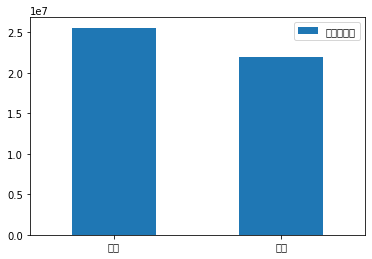

In [ ]:
holiday_mean_revenue = holiday_revenue / holiday_count
weekday_mean_revenue = weekday_revenue / weekday_count

temp = pd.DataFrame(np.zeros((2, 1)))
temp.loc[0] = holiday_mean_revenue
temp.loc[1] = weekday_mean_revenue
temp.index=['주말', '평일']
temp.rename({0:'평균취급액'}, axis=1, inplace=True)
temp.plot(kind='bar', rot=0)

In [ ]:
sat = pd.date_range(start='20190101', end='20200701', freq='W-SAT')
sat = [str(x)[:10] for x in sat]

sun = pd.date_range(start='20190101', end='20200701', freq='W-SUN')
sun = [str(x)[:10] for x in sun]

holiday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01',
           '2019-05-06', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13',
           '2019-10-03', '2019-10-09', '2019-12-25', '2020-06-06']

sat.extend(sun)
holiday.extend(sat)

lst = []

for i in tqdm(range(train.shape[0])):
    temp = str(train.iloc[i]['날짜'])[:10]
    if temp in holiday:
        lst.append(1)
    else:
        lst.append(0)
        
train['휴일'] = lst


lst2 = []

for i in tqdm(range(test.shape[0])):
    temp = str(test.iloc[i]['날짜'])[:10]
    if temp in holiday:
        lst2.append(1)
    else:
        lst2.append(0)
        
test['휴일'] = lst2

100%|██████████| 2891/2891 [00:00<00:00, 4574.48it/s]


### 상품명 양 끝에 공백 문자 제거

In [ ]:
train['상품명'] = [x.strip() for x in train['상품명']]
test['상품명'] = [x.strip() for x in test['상품명']]

### 노출(분) 시간 채우기
### 노출시간 NA값을 보면 전에 상품과 동시방영이라 위에 있는 값으로 채운다

In [ ]:
dtype = train.dtypes
n_na = train.isna().sum(axis=0).tolist()
pct_na = (train.isna().sum(axis=0)*100 / train.shape[0]).tolist()

dic = {'dtype':dtype, 'NA개수':n_na, 'NA비율':pct_na}

pd.DataFrame(dic).T

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,시,분,요일,휴일
dtype,datetime64[ns],object,object,object,object,object,int64,int64,datetime64[ns],int64,int64,object,int64
NA개수,0,14976,0,0,0,0,0,0,0,0,0,0,0
NA비율,0.00,42.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# NaN값 미리 0으로 채워놓기
train['노출(분)'].fillna(0, inplace=True)
test['노출(분)'].fillna(0, inplace=True)

# int형으로 type 변경
train['노출(분)'] = train['노출(분)'].astype('int')
test['노출(분)'] = test['노출(분)'].astype('int')

In [ ]:
lst = [train.iloc[0]['노출(분)']]

# 채우려는 값
fill = train.iloc[0]['노출(분)']

for i in tqdm(range(1, train.shape[0])):
    # 값이 존재하면 채우려는 값을 바꿔준다
    if train.iloc[i]['노출(분)'] != 0:
        fill = train.iloc[i]['노출(분)']
        lst.append(fill)
    # 값이 없으면 현재의 fill값으로 채운다
    else:
        lst.append(fill)
        
train['노출(분)'] = lst

100%|██████████| 35378/35378 [00:10<00:00, 3289.72it/s]


In [ ]:
lst = [test.iloc[0]['노출(분)']]

# 채우려는 값
fill = test.iloc[0]['노출(분)']

for i in tqdm(range(1, test.shape[0])):
    # 값이 존재하면 채우려는 값을 바꿔준다
    if test.iloc[i]['노출(분)'] != 0:
        fill = test.iloc[i]['노출(분)']
        lst.append(fill)
    # 값이 없으면 현재의 fill값으로 채운다
    else:
        lst.append(fill)
        
test['노출(분)'] = lst

100%|██████████| 2890/2890 [00:01<00:00, 2820.65it/s]


### 계절 변수 생성

In [ ]:
spring = ['03', '04', '05']
summer = ['06', '07', '08']
fall = ['9', '10', '11']
winter = ['12', '01', '02']

season = []

for i in tqdm(range(train.shape[0])):
    if str(train.iloc[i,0])[5:7] in spring:
        season.append(0)
    elif str(train.iloc[i,0])[5:7] in summer:
        season.append(1)
    elif str(train.iloc[i,0])[5:7] in fall:
        season.append(2)
    else:
        season.append(3)

train['season'] = season


season2 = []

for i in tqdm(range(test.shape[0])):
    if str(test.iloc[i,0])[5:7] in spring:
        season2.append(0)
    elif str(test.iloc[i,0])[5:7] in summer:
        season2.append(1)
    elif str(test.iloc[i,0])[5:7] in fall:
        season2.append(2)
    else:
        season2.append(3)

test['season'] = season2

100%|██████████| 2891/2891 [00:00<00:00, 40951.20it/s]


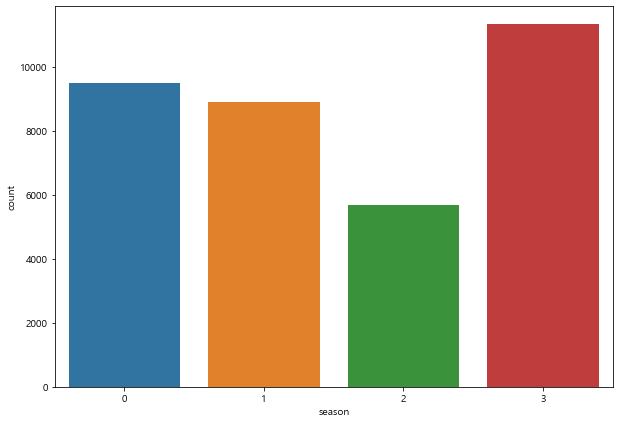

In [ ]:
sns.countplot(train['season'])

### 1일 기준으로 해당상품 노출 횟수

In [ ]:
cnt = []

for i in tqdm(train['날짜'].value_counts().sort_index().index.tolist()):
    temp = train[train['날짜'] == i]
    dic = {}

    for i in range(temp.shape[0]):
        temp2 = temp.iloc[i]['상품명']
        if dic.get(temp2) == None:
            dic[temp2] = 1
        else:
            dic[temp2] += 1

        cnt.append(dic[temp2])
    
train['노출횟수'] = cnt

100%|██████████| 366/366 [00:06<00:00, 53.35it/s]


In [ ]:
cnt = []

for i in tqdm(test['날짜'].value_counts().sort_index().index.tolist()):
    temp = test[test['날짜'] == i]
    dic = {}

    for i in range(temp.shape[0]):
        temp2 = temp.iloc[i]['상품명']
        if dic.get(temp2) == None:
            dic[temp2] = 1
        else:
            dic[temp2] += 1

        cnt.append(dic[temp2])
    
test['노출횟수'] = cnt

100%|██████████| 31/31 [00:00<00:00, 53.74it/s]


### 주문량 변수 만들기

In [ ]:
train['주문량'] = train['취급액'] / train['판매단가']

### 판매단가등급 column 만들기
### 평균판매단가가 낮을수록 더 많이 팔렸다

Text(0.5, 1.0, '상품군별 평균 취급액')

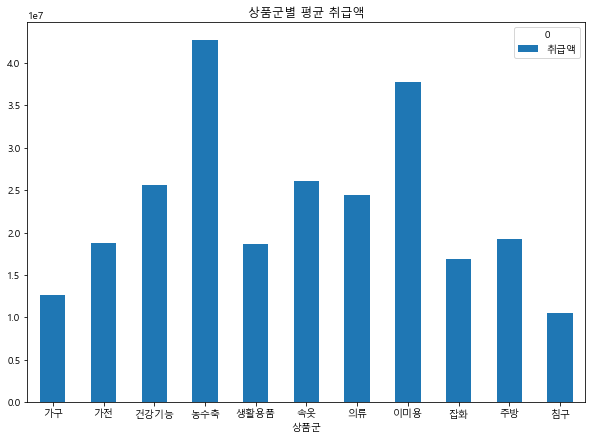

In [ ]:
final.pivot_table(index='상품군', aggfunc='mean', values='취급액').plot(kind='bar', rot=0)
plt.title('상품군별 평균 취급액')

Text(0.5, 1.0, '상품군별 평균 판매단가')

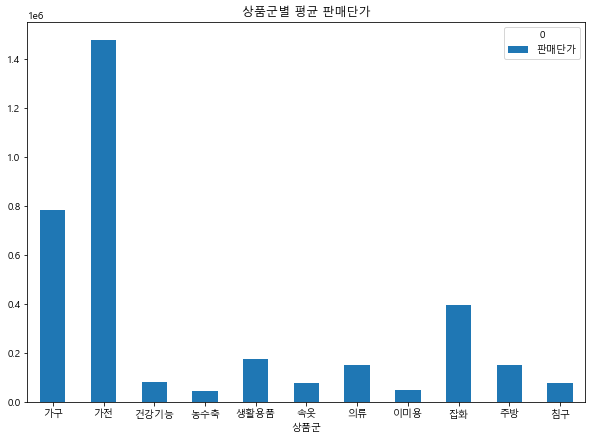

In [ ]:
final.pivot_table(index='상품군', aggfunc='mean', values='판매단가').plot(kind='bar', rot=0)
plt.title('상품군별 평균 판매단가')

In [ ]:
temp = train.pivot_table(index='판매단가', aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False)

In [ ]:
np.mean(temp.iloc[:129].index)

83329.8449612403

In [ ]:
np.mean(temp.iloc[129:(129+129)].index)

791922.480620155

In [ ]:
lst = []

for i in tqdm(range(train.shape[0])):
    temp = train.iloc[i]['판매단가']
    if temp <= 80000:
        lst.append(1)
    elif (temp >= 80000) & (temp < 800000):
        lst.append(2)
    else:
        lst.append(3)
        
train['판매단가등급'] = lst


lst2 = []

for i in tqdm(range(test.shape[0])):
    temp = test.iloc[i]['판매단가']
    if temp <= 80000:
        lst2.append(1)
    elif (temp >= 80000) & (temp < 800000):
        lst2.append(2)
    else:
        lst2.append(3)
        
test['판매단가등급'] = lst2

100%|██████████| 2891/2891 [00:00<00:00, 5112.99it/s]


### 상품명을 기준으로 embedding 행렬 만들기

In [ ]:
# 훈련 및 테스트 셋에서 상품명 컬럼만 뽑아서 데이터셋 만들기
train_product = train[['상품명']]
test_product = test[['상품명']]
data = pd.concat([train_product, test_product], axis = 0)
data = data.reset_index(drop = True)
data

,상품명
0,테이트 남성 셀린니트3종
1,테이트 여성 셀린니트3종
2,테이트 남성 셀린니트3종
3,테이트 여성 셀린니트3종
4,테이트 남성 셀린니트3종
...,...
41195,쉴렉스 안마의자 렌탈서비스
41196,쉴렉스 안마의자 렌탈서비스
41197,쉴렉스 안마의자 렌탈서비스
41198,아놀드파마 티셔츠레깅스세트


In [ ]:
# 전체 상품명 데이터에서 한글만 남기기
for k in tqdm(range(len(data))):
    # 한글만 남기기
    hangul = re.compile('[^ㄱ-ㅣ가-힣]+')
    data['상품명'][k] = hangul.sub(' ', data['상품명'][k])

100%|██████████| 41200/41200 [00:10<00:00, 4055.87it/s]


In [ ]:
# 한글 상품명에서 명사만 추출하기
okt = Okt()
for k in tqdm(range(len(data))):
    data['상품명'][k] = okt.nouns(data['상품명'][k])

100%|██████████| 41200/41200 [01:02<00:00, 656.20it/s]


In [ ]:
data.head()

,상품명
0,"[테이, 트, 남성, 셀린, 니트, 종]"
1,"[테이, 트, 여성, 셀린, 니트, 종]"
2,"[테이, 트, 남성, 셀린, 니트, 종]"
3,"[테이, 트, 여성, 셀린, 니트, 종]"
4,"[테이, 트, 남성, 셀린, 니트, 종]"


In [ ]:
# 단어 집합 만들기
s = set()
for i in tqdm(range(data.shape[0])):
  for j in data.iloc[i]['상품명']:
    s.add(j)

100%|██████████| 41200/41200 [00:04<00:00, 9452.15it/s]


In [ ]:
# 추출 된 명사가 컬럼으로 이루어진 희소행렬 생성
emb_df = pd.DataFrame(np.zeros((data.shape[0], len(s))), columns=list(s))

# 희소행렬 값 채우기
for i in tqdm(range(data.shape[0])):
  for j in data.iloc[i]['상품명']:
    emb_df.iloc[i][j] = 1

emb_df

100%|██████████| 41200/41200 [00:25<00:00, 1621.77it/s]


,백김치,구름,스파,쇼케이스,총각김치,그렉,기간,특등,근육통,보험,웨이,듀엣,중남미,쿨잠,베르사유,쉬반,루이띠,스케,새치,로베르,빗살,트리플,원목,보정,벨드쥬르,동태,텐션,오렌지,재,막,트렁크,하임,낙곱새,멀티,관리,모크넥,쿡,마담,웨어,레비,...,배드,방한,문어,바스,다이아,하부,동전,김정문,아이비,헤르,포기,커피포트,코리아,이스트,디즈니,매쉬,다이얼,제이,대리,포,투숄더,종,사기,랫,텐셀,생활비,파뷔,오징어,럭셔리,마,세미,한일,캐치온,뮤즈,감탄,오렐,테,브로,쇼츠,스트레칭
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41195,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
41196,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
41197,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
41198,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [ ]:
emb_df.sum(axis=1)

0       6.00
1       6.00
2       6.00
3       6.00
4       6.00
        ... 
41195   5.00
41196   5.00
41197   5.00
41198   5.00
41199   5.00
Length: 41200, dtype: float64

In [ ]:
emb_df = pd.read_csv("/content/drive/Shared drives/빅콘테스트2020/data/2020빅콘테스트/01_제공데이터/emb_df.csv")
emb_df.drop(['Unnamed: 0'], axis=1, inplace=True)
emb_df

,흥양,프린팅,시래기,홍어,안국루테,클렌,배터리,어스,캠프,신,컬럼비아,노,대자리,진액,양태,호빵,약,말랭이,클란츠,안마,젠트,큐,메모리,굴비,시어서커,이크,플랩,터틀넥,스팀,살롱,인버터,농원,꼬리곰탕,국수,분리,티슈,두,제옥스,순면,황사,...,엑슬,레스,렌,아트,한장,간장,체증,킹스,쿠킹,히터,폼폼,미란다,싹,더탑,수련,캐시,가능,야생화,영광군,쇼케이스,숄더백,감성,깍두기,렌탈,풀,레깅스,링,단순,돌침대,로퍼,스파,로션,히트,베니스,하프,화장,퍼니쿡,모닝,캣,베드룸
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38265,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
38266,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
38267,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
38268,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [ ]:
# 행렬분해
svd_model = TruncatedSVD(n_components=165, algorithm='randomized', n_iter=50, random_state=321)
svd_model.fit(emb_df.T)

TruncatedSVD(algorithm='randomized', n_components=165, n_iter=50,
             random_state=321, tol=0.0)

In [ ]:
temp = pd.DataFrame(svd_model.components_.T)
train = pd.concat([train, temp.iloc[:35379]], axis=1)
test = pd.concat([test.reset_index().drop(['index'], axis=1), temp.iloc[35379:].reset_index().drop(['index'], axis=1)], axis=1)

In [ ]:
train = pd.read_csv('/content/drive/Shared drives/빅콘테스트2020/data/final_train.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### train / test split
### * train data안에서의 주문량만 학습하기 위해 미리 분리

In [ ]:
train_train, train_test = [], []

np.random.seed(510)

idx = np.random.choice(train.shape[0], size=round(train.shape[0] * 0.8), replace=False)

for i in tqdm(range(train.shape[0])):
    if i in idx:
        train_train.append(i)
    else:
        train_test.append(i)
        
print('train_train :', len(train_train))
print('train_test :', len(train_test))

100%|██████████| 35379/35379 [00:00<00:00, 62398.25it/s]

train_train : 28303
train_test : 7076


In [ ]:
train_data = train.iloc[train_train,:]
test_data = train.iloc[train_test,:]

print(train_data.shape)
print(test_data.shape)

(28303, 182)
(7076, 182)


### 주문량에따른 시간대별 등급

In [ ]:
temp = train_data.pivot_table(index=['시'], aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False)


dic = {'1':temp.index[:5].tolist(),
       '2':temp.index[5:(5+5)].tolist(),
       '3':temp.index[(5+5):(5+5+6)].tolist(),
       '4':temp.index[(5+5+6):].tolist()}

print('학습 data 중 train \n')
lst = []

for i in tqdm(range(train_data.shape[0])):
    temp2 = train_data.iloc[i]['시']
    if temp2 in dic['1']:
        lst.append(0)
    elif temp2 in dic['2']:
        lst.append(1)
    elif temp2 in dic['3']:
        lst.append(2)
    else:
        lst.append(3)

train_data['시등급'] = lst

print('학습 data 중 test \n')
lst2 = []

for i in tqdm(range(test_data.shape[0])):
    temp2 = test_data.iloc[i]['시']
    if temp2 in dic['1']:
        lst2.append(0)
    elif temp2 in dic['2']:
        lst2.append(1)
    elif temp2 in dic['3']:
        lst2.append(2)
    else:
        lst2.append(3)

test_data['시등급'] = lst2


# print('평가 data \n')
# lst3 = []

# for i in tqdm(range(test.shape[0])):
#     temp2 = test.iloc[i]['시']
#     if temp2 in dic['1']:
#         lst3.append(0)
#     elif temp2 in dic['2']:
#         lst3.append(1)
#     elif temp2 in dic['3']:
#         lst3.append(2)
#     elif temp2 in dic['4']:
#         lst3.append(3)
#     else:
#         lst3.append(np.nan)

# test['시등급'] = lst3

  2%|▏         | 662/28303 [00:00<00:08, 3284.56it/s]

학습 data 중 train 



100%|██████████| 28303/28303 [00:08<00:00, 3216.33it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 15%|█▍        | 1039/7076 [00:00<00:01, 3465.78it/s]

학습 data 중 test 



100%|██████████| 7076/7076 [00:02<00:00, 3341.80it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 주문량에따른 분 등급

In [ ]:
temp = train_data.pivot_table(index=['분'], aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False)


dic = {'1':temp.index[:3].tolist(),
       '2':temp.index[3:(3+4)].tolist(),
       '3':temp.index[(3+4):].tolist()}

print('학습 data 중 train \n')
lst = []

for i in tqdm(range(train_data.shape[0])):
    temp2 = train_data.iloc[i]['분']
    if temp2 in dic['1']:
        lst.append(0)
    elif temp2 in dic['2']:
        lst.append(1)
    else:
        lst.append(2)

train_data['분등급'] = lst

print('학습 data 중 test \n')
lst2 = []

for i in tqdm(range(test_data.shape[0])):
    temp2 = test_data.iloc[i]['분']
    if temp2 in dic['1']:
        lst2.append(0)
    elif temp2 in dic['2']:
        lst2.append(1)
    else:
        lst2.append(2)


test_data['분등급'] = lst2


# print('평가 data \n')
# lst3 = []

# for i in tqdm(range(test.shape[0])):
#     temp2 = test.iloc[i]['분']
#     if temp2 in dic['1']:
#         lst3.append(0)
#     elif temp2 in dic['2']:
#         lst3.append(1)
#     elif temp2 in dic['3']:
#         lst3.append(2)
#     else:
#         lst3.append(np.nan)

# test['분등급'] = lst3

  2%|▏         | 608/28303 [00:00<00:09, 3034.22it/s]

학습 data 중 train 



100%|██████████| 28303/28303 [00:08<00:00, 3230.93it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  9%|▉         | 637/7076 [00:00<00:02, 3113.85it/s]

학습 data 중 test 



100%|██████████| 7076/7076 [00:02<00:00, 3173.26it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 주문량에따른 노출횟수 등급

In [ ]:
temp = train_data.pivot_table(index=['노출횟수'], aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False)


dic = {'1':temp.index[:3].tolist(),
       '2':temp.index[3:(3+3)].tolist(),
       '3':temp.index[(3+3):(3+3+3)].tolist(),
       '4':temp.index[(3+3+3):].tolist()}

print('학습 data 중 train \n')
lst = []

for i in tqdm(range(train_data.shape[0])):
    temp2 = train_data.iloc[i]['노출횟수']
    if temp2 in dic['1']:
        lst.append(0)
    elif temp2 in dic['2']:
        lst.append(1)
    elif temp2 in dic['3']:
        lst.append(2)
    else:
        lst.append(3)

train_data['노출횟수등급'] = lst

print('학습 data 중 test \n')
lst2 = []

for i in tqdm(range(test_data.shape[0])):
    temp2 = test_data.iloc[i]['노출횟수']
    if temp2 in dic['1']:
        lst2.append(0)
    elif temp2 in dic['2']:
        lst2.append(1)
    elif temp2 in dic['3']:
        lst2.append(2)
    else:
        lst2.append(3)

test_data['노출횟수등급'] = lst2


# print('평가 data \n')
# lst3 = []

# for i in tqdm(range(test.shape[0])):
#     temp2 = test.iloc[i]['노출횟수']
#     if temp2 in dic['1']:
#         lst3.append(0)
#     elif temp2 in dic['2']:
#         lst3.append(1)
#     elif temp2 in dic['3']:
#         lst3.append(2)
#     elif temp2 in dic['4']:
#         lst3.append(3)
#     else:
#         lst3.append(np.nan)

# test['노출횟수등급'] = lst3

  2%|▏         | 671/28303 [00:00<00:08, 3267.12it/s]

학습 data 중 train 



100%|██████████| 28303/28303 [00:08<00:00, 3241.27it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  8%|▊         | 601/7076 [00:00<00:02, 3009.44it/s]

학습 data 중 test 



100%|██████████| 7076/7076 [00:02<00:00, 3138.03it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 평균 주문량 column 생성

In [ ]:
# train_data
lst = ['노출(분)', '상품군', ['시', '분'], '요일', '휴일', 'season', '노출횟수', '노출횟수등급', '시등급', '분등급', '판매단가등급']


for i in lst:
    temp = train_data.pivot_table(index=i, aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False).reset_index()
    if str(type(i)) == "<class 'list'>":
        col = []
        string = ''
        for j in i:
            col.append(j)
            string += j+'_'
        string += '주문량'
        col.append(string)
        temp.columns = col
    else:
        temp.columns= [i, str(i)+'_주문량']
    train_data = pd.merge(train_data, temp, how='left', on=i)

In [ ]:
# test_data
lst = ['노출(분)', '상품군', ['시', '분'], '요일', '휴일', 'season', '노출횟수',  '노출횟수등급', '시등급', '분등급', '판매단가등급']

for i in lst:
    temp = train_data.pivot_table(index=i, aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False).reset_index()
    if str(type(i)) == "<class 'list'>":
        col = []
        string = ''
        for j in i:
            col.append(j)
            string += j+'_'
        string += '주문량'
        col.append(string)
        temp.columns = col
    else:
        temp.columns= [i, str(i)+'_주문량']
    test_data = pd.merge(test_data, temp, how='left', on=i)

In [ ]:
# test
lst = ['노출(분)', '상품군', ['시', '분'], '요일', '휴일', 'season', '노출횟수', '노출횟수등급', '시등급', '분등급', '판매단가등급']

for i in lst:
    # test에서는 전체 train으로 학습
    temp = train_data.pivot_table(index=i, aggfunc='mean', values='주문량').sort_values(by='주문량', ascending=False).reset_index()
    if str(type(i)) == "<class 'list'>":
        col = []
        string = ''
        for j in i:
            col.append(j)
            string += j+'_'
        string += '주문량'
        col.append(string)
        temp.columns = col
    else:
        temp.columns= [i, str(i)+'_주문량']
    test = pd.merge(test, temp, how='left', on=i)

### 원하는 column 선택

In [ ]:
col = ['노출(분)_주문량', '상품군_주문량', '시_분_주문량', '요일_주문량', '휴일_주문량', 'season_주문량', 
      	'시등급_주문량', 'season', '시', '분', '노출횟수', '노출횟수등급_주문량', '분등급_주문량', '판매단가등급', '판매단가등급_주문량']

In [ ]:
col.extend([str(x) for x in range(165)])
len(col)

180

In [ ]:
test_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,시,분,요일,휴일,season,노출횟수,주문량,판매단가등급,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,시등급,분등급,노출횟수등급,노출(분)_주문량,상품군_주문량,시_분_주문량,요일_주문량,휴일_주문량,season_주문량,노출횟수_주문량,노출횟수등급_주문량,시등급_주문량,분등급_주문량,판매단가등급_주문량
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,2019-01-01 00:00:00,6,0,화,1,3,1,52.61,1,0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,0.00,0.02,-0.00,0.02,-0.01,0.01,0.00,-0.01,0.00,-0.00,-0.01,-0.01,-0.01,0.00,0.00,-0.01,0.00,-0.00,-0.01,0.01,0.00,0.01,-0.00,0.00,0.01,2,1,3,326.71,384.33,146.02,310.56,336.04,338.26,193.31,193.40,287.09,250.22,602.94
1,2019-01-01 06:20:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,2019-01-01 00:00:00,6,20,화,1,3,2,174.31,1,0.00,0.01,-0.00,-0.00,-0.01,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.01,0.01,...,0.00,0.00,0.02,-0.00,0.02,-0.01,0.01,0.00,-0.01,0.00,-0.00,-0.01,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,-0.01,0.01,0.00,0.01,-0.00,0.00,0.01,2,0,2,326.71,384.33,242.65,310.56,336.04,338.26,327.07,328.45,287.09,355.15,602.94
2,2019-01-01 08:20:00,20,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,30061000,2019-01-01 00:00:00,8,20,화,1,3,2,501.85,1,0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,-0.00,-0.00,0.01,0.01,-0.00,...,-0.01,-0.00,-0.01,0.00,0.01,-0.01,0.01,0.00,-0.00,-0.01,0.00,0.01,-0.00,0.00,-0.00,0.00,0.00,-0.01,0.01,-0.01,0.00,-0.00,-0.00,0.00,0.01,0.00,1,0,2,326.71,384.33,349.05,310.56,336.04,338.26,327.07,328.45,378.47,355.15,602.94
3,2019-01-01 08:40:00,20,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,53542000,2019-01-01 00:00:00,8,40,화,1,3,3,893.86,1,0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,-0.00,-0.00,0.01,0.01,-0.00,...,-0.01,-0.00,-0.01,0.00,0.01,-0.01,0.01,0.00,-0.00,-0.01,0.00,0.01,-0.00,0.00,-0.00,0.00,0.00,-0.01,0.01,-0.01,0.00,-0.00,-0.00,0.00,0.01,0.00,1,0,0,326.71,384.33,485.10,310.56,336.04,338.26,449.01,450.12,378.47,355.15,602.94
4,2019-01-01 10:00:00,20,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,48799000,2019-01-01 00:00:00,10,0,화,1,3,1,610.75,1,0.00,0.01,-0.01,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.01,0.01,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,0.00,-0.00,...,0.01,0.01,0.01,-0.00,0.01,0.00,0.00,-0.00,-0.01,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,0.01,-0.00,0.00,0.01,0.00,-0.00,0.00,0.00,2,1,3,326.71,384.33,248.21,310.56,336.04,338.26,193.31,193.40,287.09,250.22,602.94


### 비어있는 값 평균으로 대체

In [ ]:
# 평균값으로 대체
for i in col:
    test_data[i].fillna(test_data[i].mean(), inplace=True)
    # test[i].fillna(test[i].mean(), inplace=True)

### 독립변수, 종속변수 분리

In [ ]:
X_train = train_data[col]
y_train = train_data['주문량']

X_test = test_data[col]
y_test = test_data['주문량']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28303, 180)
(28303,)
(7076, 180)
(7076,)


### Robust scaling

In [ ]:
scaler = RobustScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

In [ ]:
scaler = RobustScaler()

scaler.fit(X_test)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
scaler = RobustScaler()

scaler.fit(test[col])

test = pd.DataFrame(scaler.transform(test[col]), columns=test[col].columns)

In [ ]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

## 모델링

In [ ]:
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, Conv1DTranspose, concatenate, Input, add, Dropout, BatchNormalization
from tensorflow.keras import Model

def build_model(input_layer, start_neurons):
    
    conv1 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same", input_shape=(X_train.shape[1], 1))(input_layer)
    conv1 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = AveragePooling1D(2)(pool1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv1D(start_neurons * 2, 3, activation="elu", padding="same")(pool1)
    conv2 = Conv1D(start_neurons * 2, 3, activation="elu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = AveragePooling1D(2)(pool2)
    pool2 = Dropout(0.3)(pool2)

    conv3 = Conv1D(start_neurons * 2, 3, activation="elu", padding="same")(pool2)
    conv3 = Conv1D(start_neurons * 2, 3, activation="elu", padding="same")(conv3)
    pool3 = BatchNormalization()(conv3)
    pool3 = MaxPooling1D(2)(pool3)
    pool3 = Dropout(0.3)(pool3)

    convm = Conv1D(start_neurons * 4, 3, activation="elu", padding="same")(pool3)

    deconv3 = Conv1DTranspose(start_neurons * 1, 3, strides=2, padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.3)(uconv3)
    uconv3 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(uconv3)
    uconv3 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Dropout(0.3)(uconv3)

    deconv2 = Conv1DTranspose(start_neurons * 1, 3, strides=2, padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.3)(uconv2)
    uconv2 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(uconv2)
    uconv2 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Dropout(0.3)(uconv2)

    deconv1 = Conv1DTranspose(start_neurons * 1, 3, strides=2, padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.3)(uconv1)
    uconv1 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(uconv1)
    uconv1 = Conv1D(start_neurons * 1, 3, activation="elu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.3)(uconv1)

    flat = Flatten()(uconv1)
    dense1 = Dense(256, activation='elu')(flat)
    dense2 = Dense(128, activation='elu')(dense1)
    dense3 = Dense(64, activation='elu')(dense2)
    output_layer = Dense(1)(dense3)
    
    return output_layer

In [ ]:
input_layer = Input((X_train.shape[1], 1))
output_layer = build_model(input_layer, 128)

model = Model(input_layer, output_layer)

model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import keras.backend as K

adam = optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
def mape(y_true, y_pred):
  return K.mean(K.abs((y_pred - y_true) / y_true), axis=-1) * 100

def compile_and_train(model, num_epochs): 
    model.compile(optimizer=adam,
                  loss=mape,
                  metrics=['mean_squared_error'])  
    filepath = 'drive/Shared drives/빅콘테스트2020/weights/ds/' + model.name + '.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_weights_only=True, save_best_only=True, mode='auto')
    model_history = model.fit(X_train, y_train, epochs=num_epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_test, y_test), batch_size = 32)

    return model.history

In [ ]:
_=compile_and_train(model, num_epochs = 100)

## test 취급액 예측

In [ ]:
# model 생성
input_layer = Input((test.shape[1], 1))
output_layer = build_model(input_layer, 512)
model = Model(input_layer, output_layer)

# model 가중치 불러오기
model.load_weights('drive/Shared drives/빅콘테스트2020/weights/yj/functional_1.50-34.5923.hdf5')

# 주문량 예측
y_pred = model.predict(test.values)

In [ ]:
real_test['판매단가'] = real_test['판매단가'].astype('int')

real_test['취급액'] = y_pred.reshape(-1) * real_test['판매단가']
real_test

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,시,분,요일,휴일,season,노출횟수,판매단가등급
1,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1812376.46,2020-06-01,6,20,월,0,1,1,1
2,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,4199578.09,2020-06-01,6,40,월,0,1,2,1
3,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,3328317.66,2020-06-01,7,0,월,0,1,3,1
4,2020-06-01 07:20:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,15723436.29,2020-06-01,7,20,월,0,1,1,1
5,2020-06-01 07:40:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,23345492.88,2020-06-01,7,40,월,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2020-07-01 00:20:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,0.00,2020-07-01,0,20,수,0,1,1,1
2888,2020-07-01 00:40:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,0.00,2020-07-01,0,40,수,0,1,2,1
2889,2020-07-01 01:00:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,0.00,2020-07-01,1,0,수,0,1,3,1
2890,2020-07-01 01:20:00,20,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,1542003.43,2020-07-01,1,20,수,0,1,1,1
